In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import optuna
import pickle
import joblib
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Cargar los datos
df = pd.read_csv('stroke_dataset.csv')

In [49]:
# Define features
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])


In [50]:
# Separar características y objetivo
X = df[cat_cols + num_cols]
y = df['stroke']

In [51]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Función para crear el pipeline con SMOTE
def create_pipeline(classifier):
    return ImbPipeline([
        ('preprocessor', preprocessor), # preprocesamiento
        ('smote', SMOTE(random_state=42)), # Synthetic Minority Over-sampling Technique
        ('classifier', classifier) # clasificador
    ])

In [53]:
# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba)
    }

In [54]:
# Diccionario de modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [55]:
import logging
import time
import requests
import mlflow

# Configuración del registro
# logging.basicConfig(level=logging.DEBUG)  # Esto te dará más detalles sobre lo que está sucediendo

# Establecer la URI de seguimiento de MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Asegúrate de que la URI sea correcta

# Verificar si el servidor MLflow está en funcionamiento
try:
    response = requests.get("http://localhost:5000")
    if response.status_code == 200:
        print("MLflow server is running.")
    else:
        print(f"MLflow server returned status code {response.status_code}.")
except requests.ConnectionError:
    print("Failed to connect to the MLflow server.")

# Función para registrar parámetros con reintentos
def log_params_with_retry(params, max_retries=5, delay=2):
    for attempt in range(max_retries):
        try:
            mlflow.log_params(params)
            print("Parameters logged successfully.")
            break
        except mlflow.exceptions.MlflowException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                print("Max retries exceeded. Failed to log parameters.")

# Iniciar un nuevo experimento
with mlflow.start_run():
    # Entrenar y evaluar modelos
    results = {}
    best_model = None
    best_auc = 0

    for name, model in models.items():
        # Crear y ajustar el pipeline
        pipeline = create_pipeline(model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Evaluar el modelo y almacenar métricas
        metrics = evaluate_model(y_test, y_pred, y_pred_proba)
        results[name] = metrics
        
        # Registrar parámetros y métricas en MLflow
        params = {"model": name}
        log_params_with_retry(params)

        # Intentar registrar métricas
        try:
            mlflow.log_metrics(metrics)
            print(f"Metrics logged for {name}.")
        except mlflow.exceptions.MlflowException as e:
            print(f"Failed to log metrics for {name}: {e}")

        # Imprimir métricas
        print(f"\n{name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        # Actualizar el mejor modelo
        if metrics['auc'] > best_auc:
            best_auc = metrics['auc']
            best_model = (name, pipeline)

    print(f"\nBest model: {best_model[0]} with AUC = {best_auc:.4f}")


DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:5000
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET / HTTP/11" 200 645
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/create HTTP/11" 200 1014
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2


MLflow server is running.
Parameters logged successfully.
Metrics logged for Logistic Regression.

Logistic Regression:
accuracy: 0.7462
precision: 0.1509
recall: 0.7963
f1: 0.2537
auc: 0.8481


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 254


Attempt 1 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'Random Forest'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 254


Attempt 2 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'Random Forest'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 254


Attempt 3 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'Random Forest'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 254


Attempt 4 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'Random Forest'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 254
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2


Attempt 5 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'Random Forest'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.
Max retries exceeded. Failed to log parameters.
Metrics logged for Random Forest.

Random Forest:
accuracy: 0.9097
precision: 0.0263
recall: 0.0185
f1: 0.0217
auc: 0.7717
[LightGBM] [Info] Number of positive: 3790, number of negative: 3790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 7580, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 1 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'LightGBM'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 2 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'LightGBM'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 3 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'LightGBM'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 4 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'LightGBM'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2


Attempt 5 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'LightGBM'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.
Max retries exceeded. Failed to log parameters.
Metrics logged for LightGBM.

LightGBM:
accuracy: 0.9107
precision: 0.0513
recall: 0.0370
f1: 0.0430
auc: 0.7765


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 248


Attempt 1 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'XGBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 248


Attempt 2 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'XGBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 248


Attempt 3 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'XGBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 248


Attempt 4 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'XGBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 248
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2


Attempt 5 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'XGBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.
Max retries exceeded. Failed to log parameters.
Metrics logged for XGBoost.

XGBoost:
accuracy: 0.9147
precision: 0.1220
recall: 0.0926
f1: 0.1053
auc: 0.7722


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 1 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'CatBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 2 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'CatBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 3 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'CatBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249


Attempt 4 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'CatBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 400 249
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow/runs/get?run_uuid=b4a677b930c0459abe7e706da2a3eef3&run_id=b4a677b930c0459abe7e706da2a3eef3 HTTP/11" 200 1899
2024/10/16 18:26:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-boar-577 at: http://localhost:5000/#/experiments/0/runs/b4a677b930c0459abe7e706da2a3eef3.
2024/10/16 18:26:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:h

Attempt 5 failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'model', 'old_value': 'Logistic Regression', 'new_value': 'CatBoost'}]' for run ID='b4a677b930c0459abe7e706da2a3eef3'.
Max retries exceeded. Failed to log parameters.
Metrics logged for CatBoost.

CatBoost:
accuracy: 0.9147
precision: 0.0811
recall: 0.0556
f1: 0.0659
auc: 0.7578

Best model: Logistic Regression with AUC = 0.8481


In [56]:
# Optimización de hiperparámetros con Optuna
def objective(trial):
    if best_model[0] == 'Logistic Regression':
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
        
        # Asegurar que la penalización es compatible con el solver
        if solver == 'liblinear':
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        else:
            penalty = 'l2'  # lbfgs solo soporta 'l2' o None
        
        classifier = LogisticRegression(
            C=trial.suggest_loguniform('C', 1e-5, 1e5),
            solver=solver,
            penalty=penalty,
            random_state=42
        )
    elif best_model[0] == 'Random Forest':
        classifier = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 1000),
            max_depth=trial.suggest_int('max_depth', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
        )
    elif best_model[0] == 'LightGBM':
        classifier = LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 2, 256),
            max_depth=trial.suggest_int('max_depth', 3, 16),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000)
        )
    elif best_model[0] == 'XGBoost':
        classifier = XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 9),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            min_child_weight=trial.suggest_int('min_child_weight', 1, 300)
        )
    else:  # CatBoost
        classifier = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 100, 1000),
            depth=trial.suggest_int('depth', 4, 10),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            l2_leaf_reg=trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
            verbose=0
        )
    
    pipeline = create_pipeline(classifier)
    
# Configuración de StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        # Uso de iloc para obtener las filas correctas
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        pipeline.fit(X_train_fold, y_train_fold)
        y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        
        auc = roc_auc_score(y_val_fold, y_val_pred_proba)
        auc_scores.append(auc)
    
    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-10-16 18:26:26,159] A new study created in memory with name: no-name-96b30988-2f77-4503-a765-d17d3a45a5d9
[I 2024-10-16 18:26:26,387] Trial 0 finished with value: 0.8139816763341272 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 2.1001024862465064e-05}. Best is trial 0 with value: 0.8139816763341272.
[I 2024-10-16 18:26:26,600] Trial 1 finished with value: 0.8321417253301714 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.0008741582994619109}. Best is trial 1 with value: 0.8321417253301714.
[I 2024-10-16 18:26:26,897] Trial 2 finished with value: 0.8266410648093748 and parameters: {'solver': 'lbfgs', 'C': 0.14762957368284835}. Best is trial 1 with value: 0.8321417253301714.
[I 2024-10-16 18:26:27,174] Trial 3 finished with value: 0.8260677826085407 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.382334661085976}. Best is trial 1 with value: 0.8321417253301714.
[I 2024-10-16 18:26:27,392] Trial 4 finished with value: 0.8136679734652

In [57]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params = study.best_params
best_classifier = models[best_model[0]]
best_classifier.set_params(**best_params)
best_pipeline = create_pipeline(best_classifier)
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(C=0.006662384008119708, penalty='l1',
                                    solver='liblinear'))])

In [58]:
# Evaluar el modelo optimizado
y_pred_optimized = best_pipeline.predict(X_test)
y_pred_proba_optimized = best_pipeline.predict_proba(X_test)[:, 1]
metrics_optimized = evaluate_model(y_test, y_pred_optimized, y_pred_proba_optimized)

# Log de métricas del modelo optimizado en MLflow
mlflow.log_params(best_params)
mlflow.log_metrics(metrics_optimized)

print(f"\nBest model after optimization: {best_model[0]}")
print(f"Best parameters: {best_params}")
print("\nOptimized model metrics:")
for metric, value in metrics_optimized.items():
    print(f"{metric}: {value:.4f}")
    
# Calcular e imprimir el overfitting
y_train_pred_proba = best_pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)
overfitting = train_auc - metrics_optimized['auc']
print(f"\nTrain AUC: {train_auc:.4f}")
print(f"Overfitting: {overfitting:.4f}")


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/create HTTP/11" 200 1008
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/11" 200 2



Best model after optimization: Logistic Regression
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.006662384008119708}

Optimized model metrics:
accuracy: 0.7031
precision: 0.1377
recall: 0.8519
f1: 0.2371
auc: 0.8488

Train AUC: 0.8404
Overfitting: -0.0083


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x137a3f470>


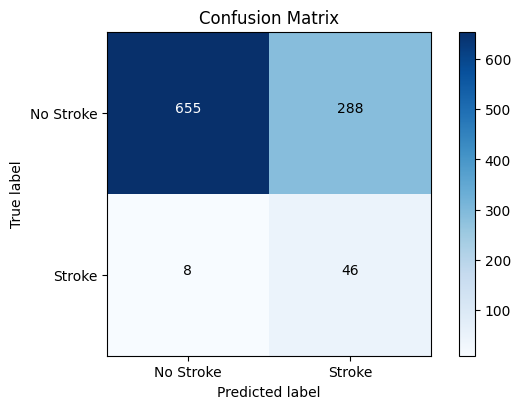

In [59]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

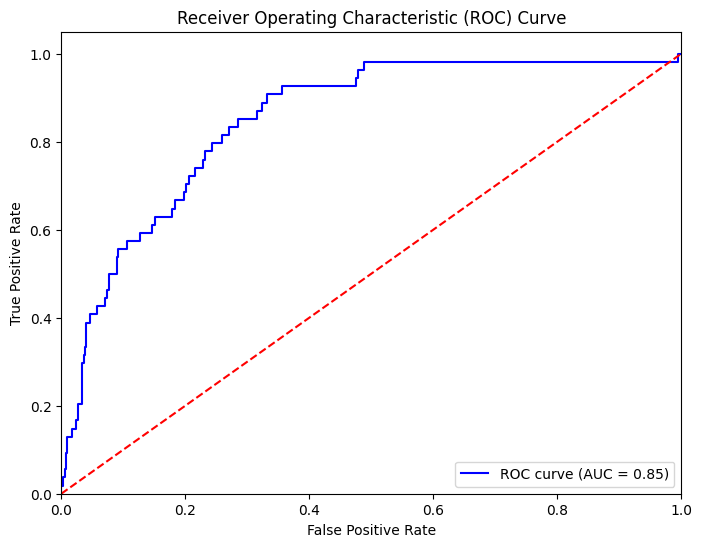

In [60]:
# Visualizar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {metrics_optimized["auc"]:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [61]:
# Guardar el mejor modelo en un archivo pickle
best_model_filename = f'best_stroke_prediction_model_{best_model[0].replace(" ", "_").lower()}.pkl'
joblib.dump(best_pipeline, best_model_filename)
print(f"\nBest model saved as: {best_model_filename}")

# Finalizar el seguimiento de MLflow
mlflow.end_run()

DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow/runs/get?run_uuid=2e7d3ce2ff704b2c8c2b66a93c4be558&run_id=2e7d3ce2ff704b2c8c2b66a93c4be558 HTTP/11" 200 2040
2024/10/16 18:27:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-asp-969 at: http://localhost:5000/#/experiments/0/runs/2e7d3ce2ff704b2c8c2b66a93c4be558.
2024/10/16 18:27:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/update HTTP/11" 200 505



Best model saved as: best_stroke_prediction_model_logistic_regression.pkl


In [62]:
# Extraer el clasificador del pipeline
best_classifier = best_pipeline.named_steps['classifier']
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)  # Transformar X_train

# Inicializar el DataFrame para la importancia
importance_df = pd.DataFrame()

# Calcular la importancia de las características
if hasattr(best_classifier, 'coef_'):  # Modelos lineales
    importance = best_classifier.coef_[0]
    features = best_pipeline.named_steps['preprocessor'].get_feature_names_out(X_train.columns)

elif hasattr(best_classifier, 'feature_importances_'):  # Modelos basados en árboles
    importance = best_classifier.feature_importances_
    features = best_pipeline.named_steps['preprocessor'].get_feature_names_out(X_train.columns)

else:
    raise ValueError("El clasificador no tiene coeficientes ni importancias para calcular.")

# Crear DataFrame de importancia
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df['Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las características
print("Importancia de las características:")
print(importance_df)

# Guardar el mejor modelo en un archivo pickle
best_model_filename = f'best_stroke_prediction_model_{best_model[0].replace(" ", "_").lower()}.pkl'
joblib.dump(best_pipeline, best_model_filename)
print(f"\nBest model saved as: {best_model_filename}")

Importancia de las características:
                                Feature  Importance
0                              num__age    1.480789
3                num__avg_glucose_level    0.149379
1                     num__hypertension    0.055402
17     cat__smoking_status_never smoked    0.047384
11         cat__work_type_Self-employed    0.000000
16  cat__smoking_status_formerly smoked    0.000000
15          cat__smoking_status_Unknown    0.000000
14            cat__Residence_type_Urban    0.000000
13            cat__Residence_type_Rural    0.000000
12              cat__work_type_children    0.000000
9               cat__work_type_Govt_job    0.000000
10               cat__work_type_Private    0.000000
8                 cat__ever_married_Yes    0.000000
7                  cat__ever_married_No    0.000000
6                      cat__gender_Male    0.000000
5                    cat__gender_Female    0.000000
4                              num__bmi    0.000000
2                    num__he

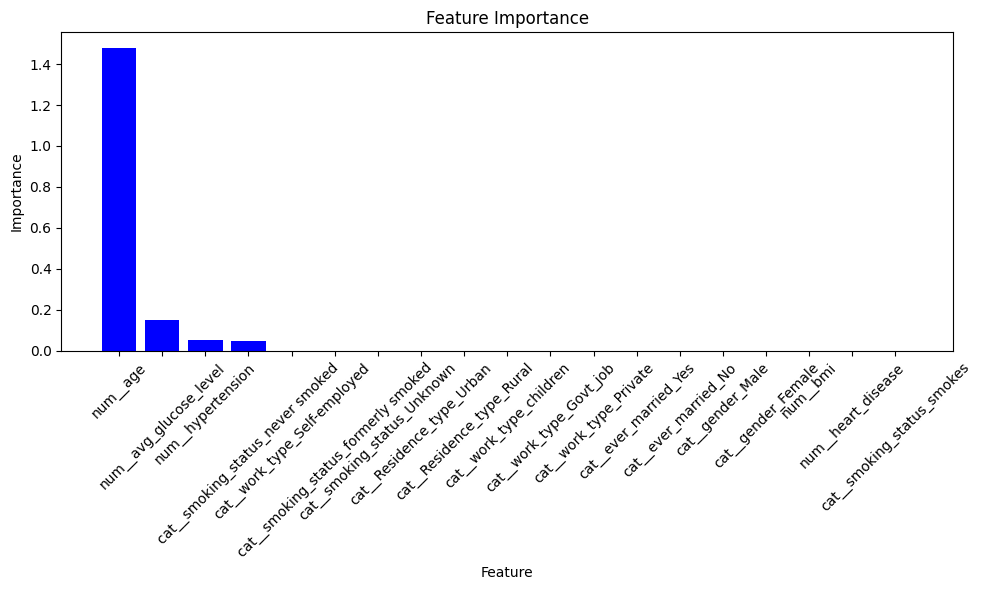

In [63]:
# Hacer una gráfica con la característica de importancias que hemos hecho en el paso anterior
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()